In [1]:
import findspark
findspark.init()

import pyspark
from pyspark import SparkConf
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql import SparkSession
sc = SparkSession.builder\
                    .master('local[*]')\
                    .appName('hello_world_app')\
                    .getOrCreate()

In [2]:
#1. 데이터 DataFrame으로 읽기
#1-1. dataframe 스키마
from pyspark.sql.types import StructType, StructField
from pyspark.sql.types import DoubleType, IntegerType, StringType

schema=StructType([\
    StructField("local",IntegerType()),\
    StructField("local_name",StringType()),\
    StructField("date",StringType()),\
    StructField("ave_temperature",DoubleType()),\
    StructField("daily_precipitation",DoubleType()),\
    StructField("ave_windspeed",DoubleType()),\
    StructField("ave_relative_humidity",DoubleType()),\
    StructField("ave_airpressure",DoubleType()),\
    StructField("the_latest_snowfall",DoubleType()),\
    StructField("ave_total_cloud",DoubleType())])

In [3]:
#1-2. 파일 불러오기
PATH='weather_20110101_20201231.csv'
file_df=sc.read.csv(PATH, header=True,schema=schema)
print(file_df)

DataFrame[local: int, local_name: string, date: string, ave_temperature: double, daily_precipitation: double, ave_windspeed: double, ave_relative_humidity: double, ave_airpressure: double, the_latest_snowfall: double, ave_total_cloud: double]


In [4]:
#1-3. 데이터 확인
file_df.show()

+-----+----------+----------+---------------+-------------------+-------------+---------------------+---------------+-------------------+---------------+
|local|local_name|      date|ave_temperature|daily_precipitation|ave_windspeed|ave_relative_humidity|ave_airpressure|the_latest_snowfall|ave_total_cloud|
+-----+----------+----------+---------------+-------------------+-------------+---------------------+---------------+-------------------+---------------+
|  108|     Seoul|2011-01-01|           -6.8|               null|          1.9|                 61.0|         1011.9|               null|            3.1|
|  108|     Seoul|2011-01-02|           -5.4|               null|          1.9|                 62.3|         1016.5|               null|            0.0|
|  108|     Seoul|2011-01-03|           -4.5|               null|          2.1|                 66.4|         1012.3|               null|            3.6|
|  108|     Seoul|2011-01-04|           -3.9|               null|          2

In [5]:
#1-4. 데이터 스키마 확인
file_df.printSchema()

root
 |-- local: integer (nullable = true)
 |-- local_name: string (nullable = true)
 |-- date: string (nullable = true)
 |-- ave_temperature: double (nullable = true)
 |-- daily_precipitation: double (nullable = true)
 |-- ave_windspeed: double (nullable = true)
 |-- ave_relative_humidity: double (nullable = true)
 |-- ave_airpressure: double (nullable = true)
 |-- the_latest_snowfall: double (nullable = true)
 |-- ave_total_cloud: double (nullable = true)



In [6]:
#2-1. 기온 열값만 뽑아내기
date_temp_df=file_df['date','ave_temperature']
date_temp_df.show()

+----------+---------------+
|      date|ave_temperature|
+----------+---------------+
|2011-01-01|           -6.8|
|2011-01-02|           -5.4|
|2011-01-03|           -4.5|
|2011-01-04|           -3.9|
|2011-01-05|           -4.0|
|2011-01-06|           -7.6|
|2011-01-07|           -7.0|
|2011-01-08|           -3.6|
|2011-01-09|           -7.0|
|2011-01-10|           -8.2|
|2011-01-11|           -5.4|
|2011-01-12|           -8.2|
|2011-01-13|           -5.9|
|2011-01-14|           -3.8|
|2011-01-15|          -12.2|
|2011-01-16|          -14.5|
|2011-01-17|           -9.7|
|2011-01-18|           -6.7|
|2011-01-19|           -6.6|
|2011-01-20|           -8.2|
+----------+---------------+
only showing top 20 rows



In [7]:
#2-2. 우선 2011년도 월별 평균기온 구하기
from pyspark.sql.functions import *

temp_2011_df=date_temp_df.select(col('date'),col('ave_temperature'))\
    .where(year('date')=='2011')\
    .select(date_format('date','MM').alias('date'),col('ave_temperature'))\
    .groupBy('date').avg()\
    .orderBy('date')
    
temp_2011_df.show()
temp_2011_df.count()
#temp_2011_df.printSchema()

+----+--------------------+
|date|avg(ave_temperature)|
+----+--------------------+
|  01|  -7.183870967741936|
|  02|  1.2214285714285713|
|  03|  3.6161290322580646|
|  04|  10.719999999999997|
|  05|  17.925806451612903|
|  06|   21.97666666666667|
|  07|   24.63870967741936|
|  08|   25.77419354838709|
|  09|               21.75|
|  10|  14.222580645161294|
|  11|   10.68666666666667|
|  12|  -0.870967741935484|
+----+--------------------+



12

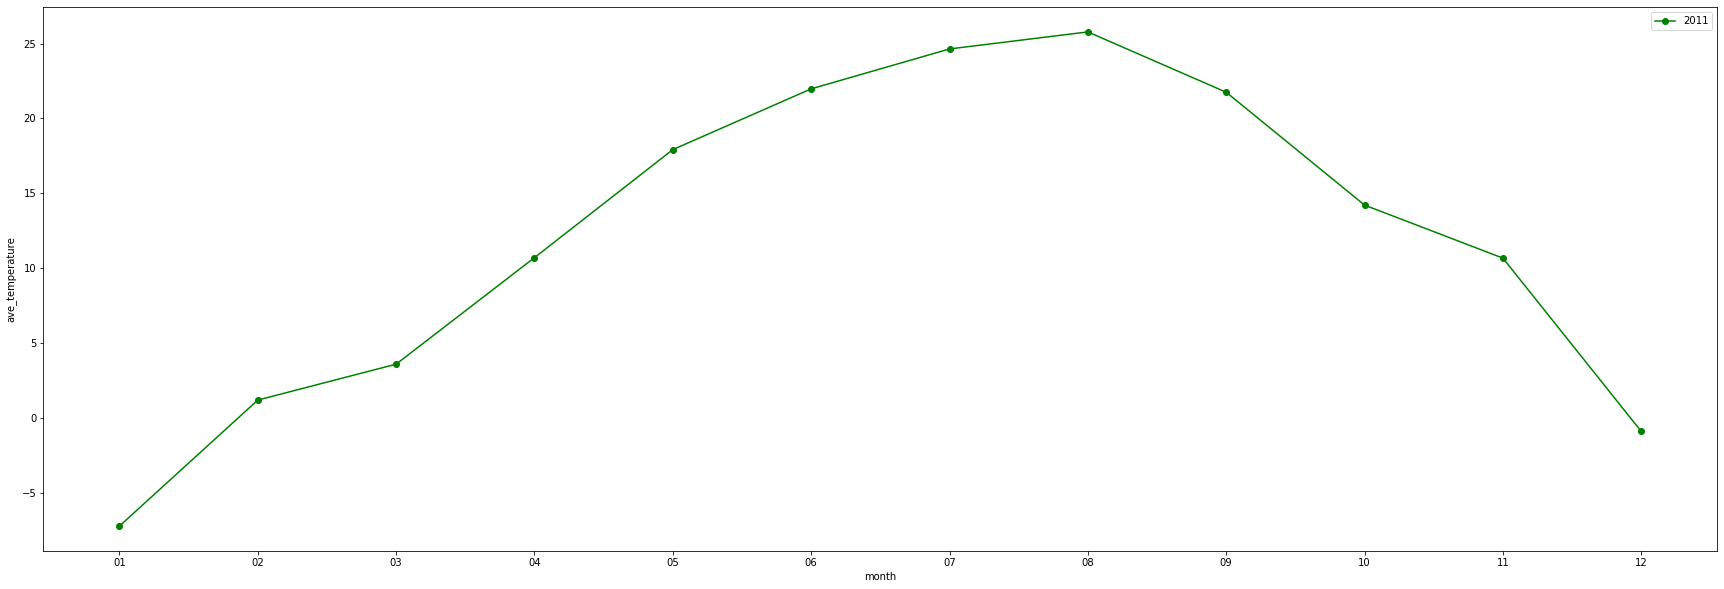

In [8]:
#3.선그래프 그리기 
from matplotlib import pyplot as plt

temp_2011_pd=temp_2011_df.toPandas()
#display(temp_2011_pd)

x_values=temp_2011_pd['date']
y_values=temp_2011_pd['avg(ave_temperature)']


#x_values=temp_2011_df.select(col('date')).collect()
#y_values=temp_2011_df.select(col('ave_temperature')).collect()
#print(y_values)
plt.figure(figsize=(30, 10))
plt.plot(x_values,y_values,color='green',marker='o')

plt.xlabel('month')
plt.ylabel('ave_temperature')
plt.legend(['2011'])
plt.show()

In [ ]:
#3-0. 년도별로 월별 평균 기온 출력
range_year=[i for i in range(2011,2021)]
temp_year=['temp_'+str(i)+'_df' for i in range_year]

print(range_year)
print(temp_year)

for i in range(len(temp_year)):
    temp_year[i]=date_temp_df.select(col('date'),col('ave_temperature'))\
        .where(year('date')==str(range_year[i]))\
        .select(date_format('date','MM').alias('date'),col('ave_temperature'))\
        .groupBy('date').avg()\
        .orderBy('date')

    #temp_year[i].show()

In [ ]:
#3-1. 그래프를 그리기 위해 pd로 변환
temp_year_pd=['temp_'+str(i)+'_pd' for i in range_year]

for i in range(len(temp_year_pd)):
    temp_year_pd[i]=temp_year[i].toPandas()
    
display(temp_year_pd[0])
    

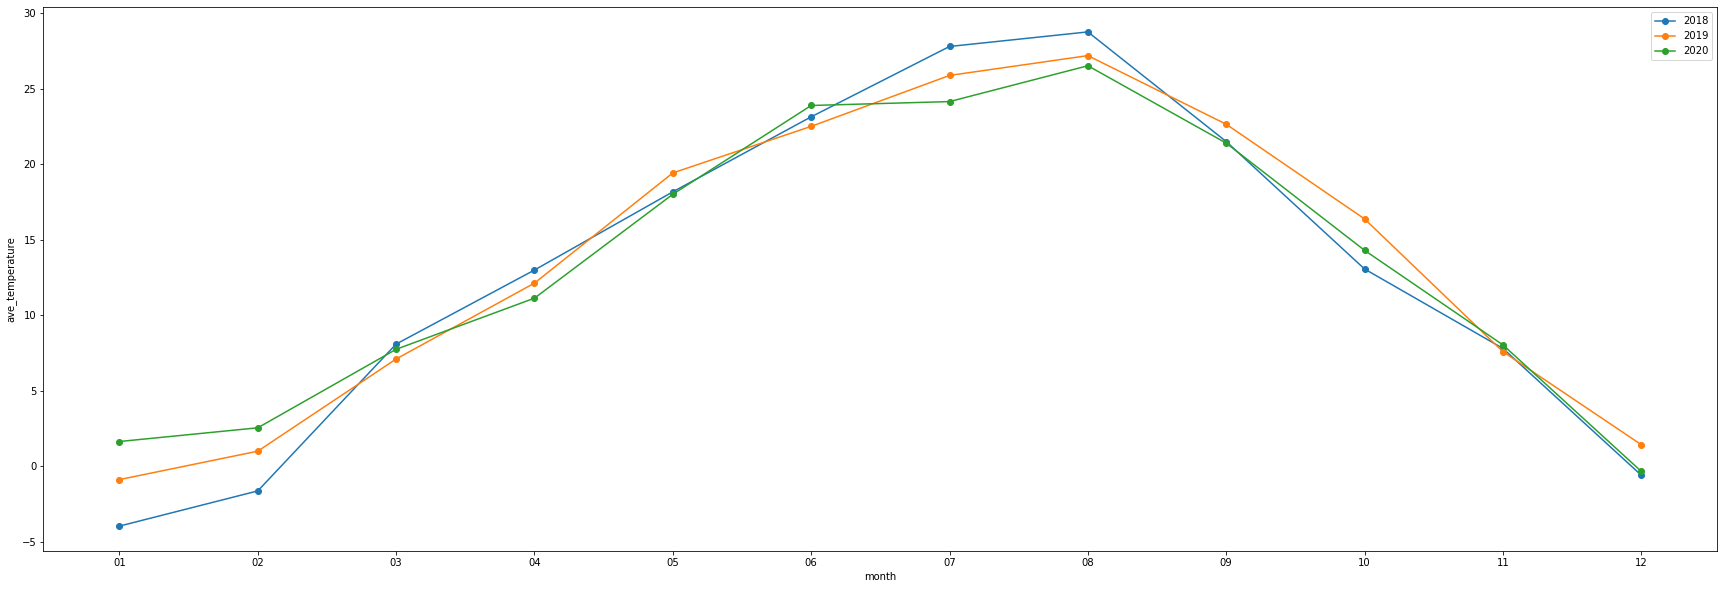

In [41]:
#3-2. 우선 3년간 선그래프 비교 (2018-2020)

#축 사이즈
plt.figure(figsize=(30, 10))

#그래프 그리기
x_values=temp_year_pd[7]['date']
y_values=temp_year_pd[7]['avg(ave_temperature)']
plt.plot(x_values,y_values,marker='o')

x_values=temp_year_pd[8]['date']
y_values=temp_year_pd[8]['avg(ave_temperature)']
plt.plot(x_values,y_values,marker='o')

x_values=temp_year_pd[9]['date']
y_values=temp_year_pd[9]['avg(ave_temperature)']
plt.plot(x_values,y_values,marker='o')

#축 라벨 표시
plt.xlabel('month')
plt.ylabel('ave_temperature')
plt.legend(['2018','2019','2020'])


plt.show()

In [11]:
#4.막대 그래프 그리기 (여러 년도 비교)
#4-0. 년도별로 월별 평균 기온 출력
range_year=[i for i in range(2011,2021)]
temp_year=['temp_'+str(i)+'_df' for i in range_year]

print(range_year)
print(temp_year)

for i in range(len(temp_year)):
    temp_year[i]=date_temp_df.select(col('date'),col('ave_temperature'))\
        .where(year('date')==str(range_year[i]))\
        .select(date_format('date','MM').alias('date'),col('ave_temperature'))\
        .groupBy('date').avg()\
        .orderBy('date')

    #temp_year[i].show()


[2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020]
['temp_2011_df', 'temp_2012_df', 'temp_2013_df', 'temp_2014_df', 'temp_2015_df', 'temp_2016_df', 'temp_2017_df', 'temp_2018_df', 'temp_2019_df', 'temp_2020_df']
+----+--------------------+
|date|avg(ave_temperature)|
+----+--------------------+
|  01|  -7.183870967741936|
|  02|  1.2214285714285713|
|  03|  3.6161290322580646|
|  04|  10.719999999999997|
|  05|  17.925806451612903|
|  06|   21.97666666666667|
|  07|   24.63870967741936|
|  08|   25.77419354838709|
|  09|               21.75|
|  10|  14.222580645161294|
|  11|   10.68666666666667|
|  12|  -0.870967741935484|
+----+--------------------+

+----+--------------------+
|date|avg(ave_temperature)|
+----+--------------------+
|  01|  -2.787096774193549|
|  02| -2.0448275862068965|
|  03|   5.090322580645162|
|  04|               12.34|
|  05|   19.73225806451613|
|  06|  24.139999999999993|
|  07|  25.412903225806453|
|  08|  27.132258064516122|
|  09|  20.9633333333

In [17]:
#4-1. 그래프를 그리기 위해 pd로 변환
temp_year_pd=['temp_'+str(i)+'_pd' for i in range_year]

for i in range(len(temp_year_pd)):
    temp_year_pd[i]=temp_year[i].toPandas()
    
display(temp_year_pd[0])
    

,date,avg(ave_temperature)
0,01,-7.183871
1,02,1.221429
2,03,3.616129
3,04,10.720000
4,05,17.925806
5,06,21.976667
6,07,24.638710
7,08,25.774194
8,09,21.750000
9,10,14.222581


In [18]:
print(temp_year_pd[0]['avg(ave_temperature)'])

0     -7.183871
1      1.221429
2      3.616129
3     10.720000
4     17.925806
5     21.976667
6     24.638710
7     25.774194
8     21.750000
9     14.222581
10    10.686667
11    -0.870968
Name: avg(ave_temperature), dtype: float64


[ 0  1  2  3  4  5  6  7  8  9 10 11]


<ipython-input-40-a5176be12088>:20: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.subplot()


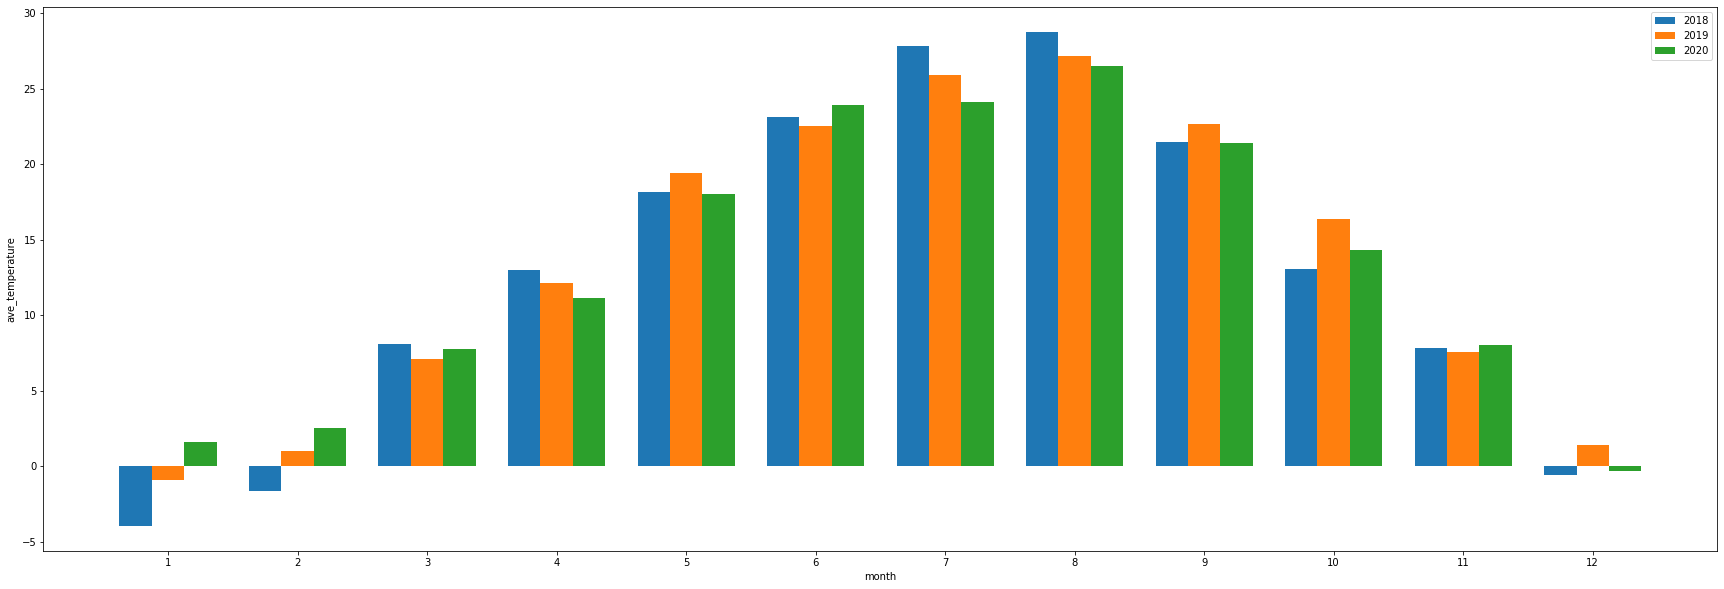

In [40]:
#4-2. 우선 3년간 막대그래프 비교 (2018-2020)
import numpy

#축 사이즈
plt.figure(figsize=(30, 10))

#그래프 그리기
X=numpy.arange(12)
print(X)
_value=temp_year_pd[7]['avg(ave_temperature)']
plt.bar(X-0.25+1,_value,width=0.25)

_value=temp_year_pd[8]['avg(ave_temperature)']
plt.bar(X+0.00+1,_value,width=0.25)

_value=temp_year_pd[9]['avg(ave_temperature)']
plt.bar(X+0.25+1,_value,width=0.25)


#축 눈금 표시
ax = plt.subplot()
ax.set_xticks([i for i in range(1,13)])
#축 라벨 표시
plt.xlabel('month')
plt.ylabel('ave_temperature')
plt.legend(['2018','2019','2020'])


plt.show()